# Bone Analysis

# Initializing the ImageJ2 gateway

PyImageJ is built on the [scyjava](https://pypi.org/project/scyjava) library, which is built on [JPype](https://jpype.readthedocs.io/) and [jgo](https://pypi.org/project/jgo). These libraries enable us to import any available Java class into our Python program, and use its full API, just as we could from within a Java program. So we import the Java runtime before importing imageJ.

In [1]:
# Imports

import scyjava
import imagej
import xarray as xr

import matplotlib.pyplot as plt
import numpy as np
import ipywidgets

from tqdm.notebook import tqdm

plt.style.use('seaborn-v0_8-paper')
scyjava.config.add_options('-Xmx6g')

import imagej
#ij = imagej.init('/Applications/Fiji.app')
ij = imagej.init(['sc.fiji:fiji:2.9.0', 
                  'org.bonej:bonej-plugins', 
                  'org.bonej:bonej-utilities', 
                  'org.bonej:bonej-ops'], 
                 add_legacy=False)
print(f"ImageJ version: {ij.getVersion()}")

Runtime = scyjava.jimport('java.lang.Runtime')
print(Runtime.getRuntime().maxMemory() // (2*2**20), " MB available to Java")


ImageJ version: 2.9.0/1.53t
2730  MB available to Java


In [2]:
# Import scijava classes using jimport
Command = scyjava.jimport('org.scijava.command.Command') # Just for the example, not necessary in the notebook
JPlugin = scyjava.jimport('org.scijava.plugin.Plugin')
Parameter = scyjava.jimport('org.scijava.plugin.Parameter')
ImagePlus = scyjava.jimport('ij.ImagePlus')

In [3]:
#assert 'ij' in locals(), "The ij variable doesn't exist. Did you assign the created gateway to a variable called ij?"
#assert hasattr(ij, 'app'), "The ij variable exists, but does not have the expected structure. Are you sure it is an ImageJ2 gateway object?"
#app_versions = {"ImageJ1": "1.53t", "ImageJ2": "2.9.0/1.53t", "Fiji": "2.9.0"}
#all_good = True
#for name, expected_version in app_versions.items():
#    app = ij.app().getApp(name)
#    actual_version = app.getVersion() if app else "None"
#    assert actual_version == expected_version, f"Expected {expected_version} for the gateway's {name} component, but it was {actual_version}."
#print("Your gateway looks good! Nice work!")

## Loading and visualizing data into ImageJ

In [4]:
with open('/Users/grokkingstuff/Sync/work/bone_analysis/data/TB5-L0-VOI1.mhd') as f:
    for line in f:
        print(line.strip())

ObjectType = Image
NDims = 3
BinaryData = True
BinaryDataByteOrderMSB = True
DimSize = 300 300 430
ElementSize = 0.0065 0.0065 0.0065
ElementType = MET_USHORT
ElementDataFile = TB5-L0-VOI1.raw


In [5]:
ij.py.run_macro("""run("MHD/MHA...", "open=/Users/grokkingstuff/Sync/work/bone_analysis/data/TB5-L0-VOI1.mhd"); run("8-bit");""")
pre_load = ij.WindowManager.getCurrentImage()
pre_load_py = ij.py.from_java(pre_load)
pre_load_java = ij.py.to_imageplus(pre_load_py)

ij.py.run_macro("""run("MHD/MHA...", "open=/Users/grokkingstuff/Sync/work/bone_analysis/data/TB5-L8-VOI1.mhd"); run("8-bit");""")
pre_failure = ij.WindowManager.getCurrentImage()
pre_failure_py = ij.py.from_java(pre_failure)
pre_failure_java = ij.py.to_imageplus(pre_failure_py)

ij.py.run_macro("""run("MHD/MHA...", "open=/Users/grokkingstuff/Sync/work/bone_analysis/data/TB5-L10-VOI1.mhd"); run("8-bit");""")
post_failure = ij.WindowManager.getCurrentImage()
post_failure_py = ij.py.from_java(post_failure)
post_failure_java = ij.py.to_imageplus(post_failure_py)

Operating in headless mode - the original ImageJ will have limited functionality.
Operating in headless mode - the WindowManager class will not be fully functional.


In [6]:
def plane(image, pos):
    """
    Slices an image plane at the given position.
    :param image: the image to slice
    :param pos: a dictionary from dimensional axis label to element index for that dimension
    """
    # Convert pos dictionary to position indices in dimension order.
    # See https://stackoverflow.com/q/39474396/1207769.
    p = tuple(pos[image.dims[d]] if image.dims[d] in pos else slice(None) for d in range(image.ndim))
    return image[p]

def _axis_index(image, *options):
    axes = tuple(d for d in range(image.ndim) if image.dims[d].lower() in options)
    if len(axes) == 0:
        raise ValueError(f"Image has no {options[0]} axis!")
    return axes[0]

def ndshow(image, x_axis=None, y_axis=None, immediate=False):
    if not hasattr(image, 'dims'):
        # We need dimensional axis labels!
        raise TypeError("Metadata-rich image required")

    # Infer X and/or Y axes as needed.
    if x_axis is None:
        x_axis = _axis_index(image, "x", "col")
    if y_axis is None:
        y_axis = _axis_index(image, "y", "row")

    # Build ipywidgets sliders, one per non-planar dimension.
    widgets = {}
    for d in range(image.ndim):
        if d == x_axis or d == y_axis:
            continue
        label = image.dims[d]
        widgets[label] = ipywidgets.IntSlider(description=label, max=image.shape[d]-1, continuous_update=immediate)

    # Create image plot with interactive sliders.
    def recalc(**kwargs):
        ij.py.show(plane(image, kwargs), cmap="bone")
    ipywidgets.interact(recalc, **widgets)
    


In [7]:
def dump_info(image):
    """A handy function to print details of an image object."""
    name = image.name if hasattr(image, 'name') else None # xarray
    if name is None and hasattr(image, 'getName'): name = image.getName() # Dataset
    if name is None and hasattr(image, 'getTitle'): name = image.getTitle() # ImagePlus
    print(f" name: {name or 'N/A'}")
    print(f" type: {type(image)}")
    print(f"dtype: {image.dtype if hasattr(image, 'dtype') else 'N/A'}")
    print(f"shape: {image.shape}")
    print(f" dims: {image.dims if hasattr(image, 'dims') else 'N/A'}")

print("\n  var: pre_load_py")
dump_info(pre_load_py)

print("\n  var: pre_load_java")
dump_info(pre_load_java)


  var: pre_load_py
 name: TB5-L0-VOI1.raw
 type: <class 'xarray.core.dataarray.DataArray'>
dtype: uint8
shape: (430, 300, 300)
 dims: ('pln', 'row', 'col')

  var: pre_load_java
 name: TB5-L0-VOI1.raw
 type: <java class 'ij.ImagePlus'>
dtype: N/A
shape: (300, 300, 430)
 dims: ('X', 'Y', 'Z')


## Histogram

An image histogram is a distribution showing the frequency of each gray-level value. For the provided images of dimension (430, 300, 300), the total number of voxels is 430 × 300 × 300. Histogram analysis is useful as the gray-scale values of foreground and background values are distinguished as two peaks.

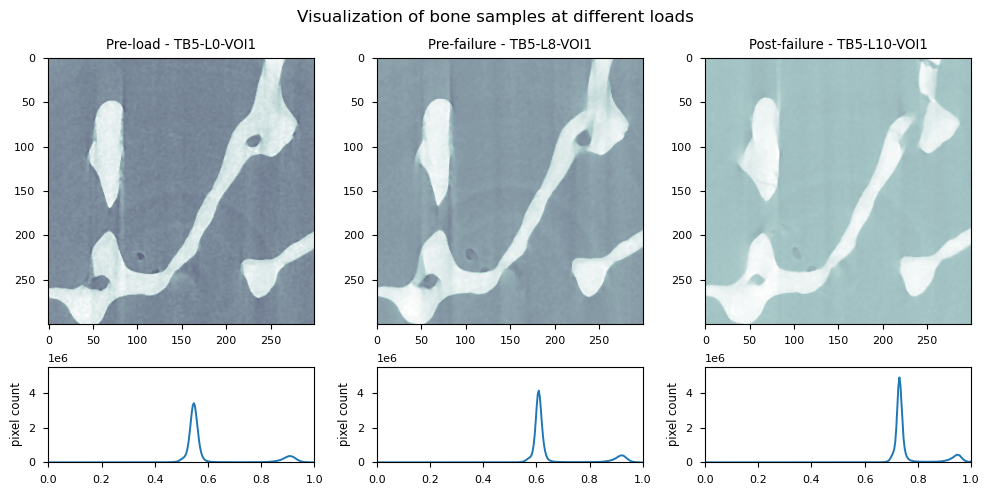

In [8]:
# configure and draw the histogram figure
fig, ax = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(10, 5), height_ratios=[3, 1])  

fig.suptitle("Visualization of bone samples at different loads")
ax[0][0].set_title("Pre-load - TB5-L0-VOI1")
ax[0][1].set_title("Pre-failure - TB5-L8-VOI1")
ax[0][2].set_title("Post-failure - TB5-L10-VOI1")

for idx, image in enumerate([pre_load_py, pre_failure_py, post_failure_py]):
    ax[0][idx].imshow(image[0,:,:], cmap="bone")    
    
    image_numpy = np.asarray(image)       
    histogram, bin_edges = np.histogram(np.interp(image_numpy, (image_numpy.min(), image_numpy.max()), (0, +1)), 
                                        bins = 256,
                                        density = False)       
    ax[1][idx].plot(bin_edges[0:-1], histogram)    
    ax[1][idx].set_ylabel("pixel count", size="small")
    ax[1][idx].set_xlim([0.0, 1.0])
    ax[1][idx].set_ylim([0.0, 5.5e6])
    ax[1][idx].yaxis.set_tick_params(labelleft=True)
    
fig.tight_layout()

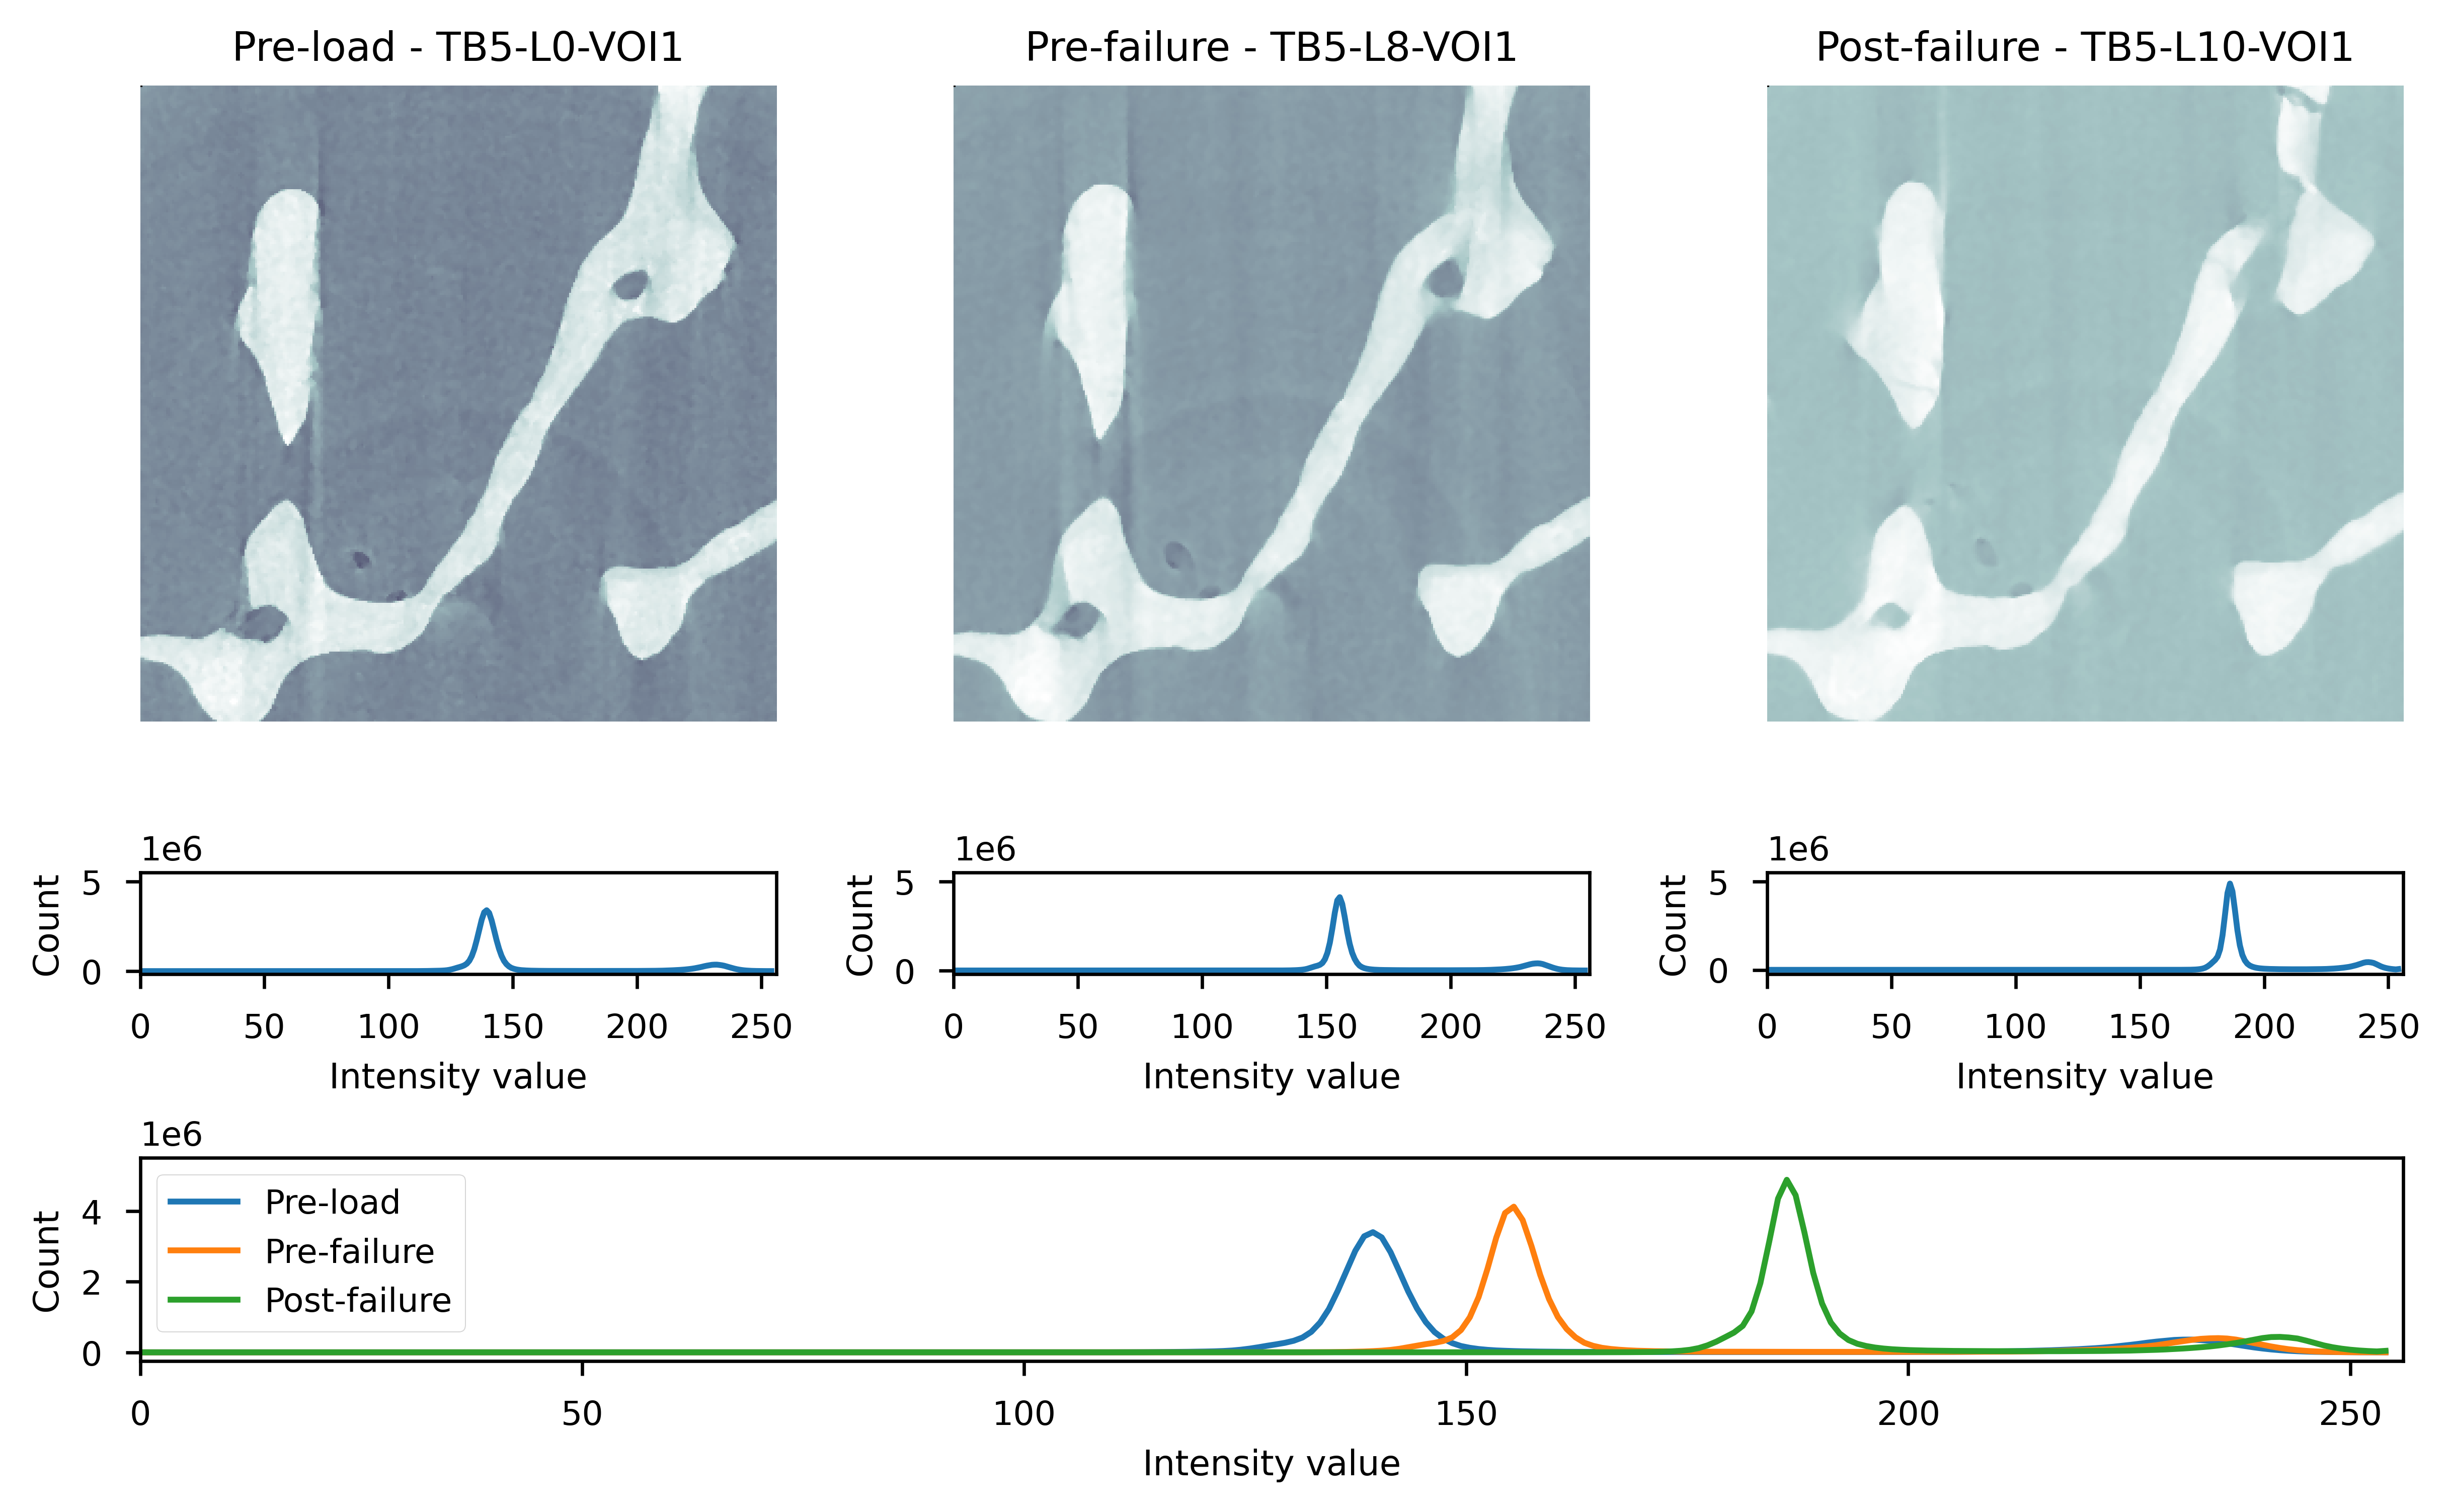

In [9]:

# Simple data to display in various forms
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

fig = plt.figure(constrained_layout=True, figsize=(8,5),dpi=600)
gs = fig.add_gridspec(3, 3, height_ratios=[8, 1, 2])

ax00 = fig.add_subplot(gs[0,0])
ax01 = fig.add_subplot(gs[0,1])
ax02 = fig.add_subplot(gs[0,2])

ax00.imshow(pre_load_py[0,:,:], cmap="bone", aspect='equal')
ax00.set_title('Pre-load - TB5-L0-VOI1')

ax01.imshow(pre_failure_py[0,:,:], cmap="bone", aspect='equal')
ax01.set_title('Pre-failure - TB5-L8-VOI1')


ax02.imshow(post_failure_py[0,:,:], cmap="bone", aspect='equal')
ax02.set_title('Post-failure - TB5-L10-VOI1')

ax00.axis('off')
ax01.axis('off')
ax02.axis('off')

ax2_ = fig.add_subplot(gs[2,:])

ax10 = fig.add_subplot(gs[1,0])
histogram, bin_edges = np.histogram(np.asarray(pre_load_py), bins = 256, density = False)
ax10.plot(bin_edges[0:-1], histogram)    
ax2_.plot(bin_edges[0:-1], histogram, label="Pre-load")    
ax10.set_ylabel("Count", size="small")
ax10.set_xlabel("Intensity value", size="small")
ax10.set_xlim([0.0, 256.0])
ax10.set_ylim([None, 5.5e6])
ax10.yaxis.set_tick_params(labelleft=True)

ax11 = fig.add_subplot(gs[1,1])
histogram, bin_edges = np.histogram(np.asarray(pre_failure_py), bins = 256, density = False)
ax11.plot(bin_edges[0:-1], histogram)    
ax2_.plot(bin_edges[0:-1], histogram, label="Pre-failure")    
ax11.set_ylabel("Count", size="small")
ax11.set_xlabel("Intensity value", size="small")
ax11.set_xlim([0.0, 256.0])
ax11.set_ylim([None, 5.5e6])
ax11.yaxis.set_tick_params(labelleft=True)

ax12 = fig.add_subplot(gs[1,2])
histogram, bin_edges = np.histogram(np.asarray(post_failure_py), bins = 256, density = False)
ax12.plot(bin_edges[0:-1], histogram)    
ax2_.plot(bin_edges[0:-1], histogram, label="Post-failure")    
ax12.set_ylabel("Count", size="small")
ax12.set_xlabel("Intensity value", size="small")
ax12.set_xlim([0.0, 256.0])
ax12.set_ylim([None, 5.5e6])
ax12.yaxis.set_tick_params(labelleft=True)
#ax12.set_title('Histogram of bone samples')

ax2_.legend(loc="upper left")
ax2_.set_ylabel("Count", size="small")
ax2_.set_xlabel("Intensity value", size="small")
ax2_.set_xlim([0.0, 256.0])
ax2_.set_ylim([None, 5.5e6])
#ax2_.set_title('Histogram of bone samples')

#fig.add_subplot(gs[0,1]).imshow(pre_failure_py[0,:,:], cmap="bone")
#fig.add_subplot(gs[0,2]).imshow(post_failure_py[0,:,:], cmap="bone")


plt.savefig('histogram.jpeg')
plt.show()


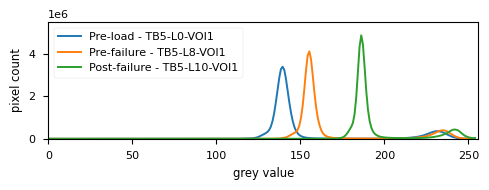

In [10]:
# configure and draw the histogram figure
fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(5, 2)) #, height_ratios=[3, 1])  

#fig.suptitle("Visualization of bone samples at different loads")
#ax[0][0].set_title("Pre-load - TB5-L0-VOI1")
#ax[0][1].set_title("Pre-failure - TB5-L8-VOI1")
#ax[0][2].set_title("Post-failure - TB5-L10-VOI1")

histogram, bin_edges = np.histogram(np.asarray(pre_load_py), bins = 256, density = False)       
ax.plot(bin_edges[0:-1], histogram, label = "Pre-load - TB5-L0-VOI1")    

histogram, bin_edges = np.histogram(np.asarray(pre_failure_py), bins = 256, density = False)       
ax.plot(bin_edges[0:-1], histogram, label = "Pre-failure - TB5-L8-VOI1")    

histogram, bin_edges = np.histogram(np.asarray(post_failure_py), bins = 256, density = False)       
ax.plot(bin_edges[0:-1], histogram, label = "Post-failure - TB5-L10-VOI1")    

ax.set_xlabel("grey value", size="small")
ax.set_ylabel("pixel count", size="small")
ax.set_xlim([0.0, 256.0])
ax.set_ylim([0.0, 5.5e6])
ax.yaxis.set_tick_params(labelleft=True)

ax.legend(loc="upper left")
    
fig.tight_layout()

# Filtering & Thresholding

In [11]:

# ij.op().help("copy.rai")
# copy = ij.op().run("copy.rai", pre_load_java)

## Filtering

In [12]:
# ij.op().help("filter.dog")
# ij.op().help("filter.gauss")

### filter_gauss

In [13]:
def filter_gauss(image, sigma=None):
    """
    >>> ij.op().help("filter.gauss")
    
    'Available operations:
	(RandomAccessibleInterval out) =
	net.imagej.ops.filter.gauss.DefaultGaussRA(
		RandomAccessibleInterval out,
		RandomAccessible in,
		double[] sigmas)
	(RandomAccessibleInterval out?) =
	net.imagej.ops.filter.gauss.GaussRAISingleSigma(
		RandomAccessibleInterval out?,
		RandomAccessibleInterval in,
		double sigma,
		OutOfBoundsFactory outOfBounds?)
	(RandomAccessibleInterval out?) =
	net.imagej.ops.filter.gauss.DefaultGaussRAI(
		RandomAccessibleInterval out?,
		RandomAccessibleInterval in,
		double[] sigmas,
		OutOfBoundsFactory outOfBounds?)'
    """
    
    if sigma is None:
        sigma = 3
    
    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(np.zeros(image.shape), 
                          coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    # ImageJ Operations work in Java. The to_java acts as a thin wrapper.
    ij.op().filter().gauss(ij.py.to_java(result), ij.py.to_java(image), sigma)

    return result

### filter_variance

In [14]:
def filter_variance(image, radius=None):
    """
    >>> ij.op().help("filter.variance")
    
    'Available operations:
	(IterableInterval out) =
	net.imagej.ops.filter.variance.DefaultVarianceFilter(
		IterableInterval out,
		RandomAccessibleInterval in,
		Shape shape,
		OutOfBoundsFactory outOfBoundsFactory?)'
    """
    
    import scyjava
    HyperSphereShape = scyjava.jimport("net.imglib2.algorithm.neighborhood.HyperSphereShape")
    if radius is None:
        shape = HyperSphereShape(3)
    else:
        shape = HyperSphereShape(radius)
        
    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(np.zeros(image.shape), 
                          coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    # ImageJ Operations work in Java. The to_java acts as a thin wrapper.
    ij.op().filter().variance(ij.py.to_java(result), ij.py.to_java(image), shape)

    return result

### filter_mean

In [15]:
def filter_mean(image, radius=None):
    """
    >>> ij.op().help("filter.mean")
    
    'Available operations:
	(IterableInterval out) =
	net.imagej.ops.filter.mean.DefaultMeanFilter(
		IterableInterval out,
		RandomAccessibleInterval in,
		Shape shape,
		OutOfBoundsFactory outOfBoundsFactory?)'
    """
    
    import scyjava
    HyperSphereShape = scyjava.jimport("net.imglib2.algorithm.neighborhood.HyperSphereShape")
    if radius is None:
        shape = HyperSphereShape(3)
    else:
        shape = HyperSphereShape(radius)
        
    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(np.zeros(image.shape), 
                          coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    # ImageJ Operations work in Java. The to_java acts as a thin wrapper.
    ij.op().filter().mean(ij.py.to_java(result), ij.py.to_java(image), shape)

    return result

### filter_median

In [16]:
def filter_median(image, radius=None):
    """
    >>> ij.op().help("filter.median")
    
    'Available operations:
	(IterableInterval out) =
	net.imagej.ops.filter.median.DefaultMedianFilter(
		IterableInterval out,
		RandomAccessibleInterval in,
		Shape shape,
		OutOfBoundsFactory outOfBoundsFactory?)'
    """
    
    import scyjava
    HyperSphereShape = scyjava.jimport("net.imglib2.algorithm.neighborhood.HyperSphereShape")
    if radius is None:
        shape = HyperSphereShape(3)
    else:
        shape = HyperSphereShape(radius)
        
    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(np.zeros(image.shape), 
                          coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    # ImageJ Operations work in Java. The to_java acts as a thin wrapper.
    ij.op().filter().median(ij.py.to_java(result), ij.py.to_java(image), shape)

    return result

### filter_minimum

In [17]:
def filter_minimum(image, radius=None):
    """
    >>> ij.op().help("filter.min")
    'Available operations:
	(IterableInterval out) =
	net.imagej.ops.filter.min.DefaultMinFilter(
		IterableInterval out,
		RandomAccessibleInterval in,
		Shape shape,
		OutOfBoundsFactory outOfBoundsFactory?)'
    """
    
    import scyjava
    HyperSphereShape = scyjava.jimport("net.imglib2.algorithm.neighborhood.HyperSphereShape")
    if radius is None:
        shape = HyperSphereShape(3)
    else:
        shape = HyperSphereShape(radius)
        
    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(np.zeros(image.shape), 
                          coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    # ImageJ Operations work in Java. The to_java acts as a thin wrapper.
    ij.op().filter().min(ij.py.to_java(result), ij.py.to_java(image), shape)

    return result

### filter_maximum

In [18]:
def filter_maximum(image, radius=None):
    """
    >>> ij.op().help("filter.max")
    'Available operations:
	(IterableInterval out) =
	net.imagej.ops.filter.max.DefaultMaxFilter(
		IterableInterval out,
		RandomAccessibleInterval in,
		Shape shape,
		OutOfBoundsFactory outOfBoundsFactory?)'
    """
    
    import scyjava
    HyperSphereShape = scyjava.jimport("net.imglib2.algorithm.neighborhood.HyperSphereShape")
    if radius is None:
        shape = HyperSphereShape(3)
    else:
        shape = HyperSphereShape(radius)
        
    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(np.zeros(image.shape), 
                          coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    # ImageJ Operations work in Java. The to_java acts as a thin wrapper.
    ij.op().filter().max(ij.py.to_java(result), ij.py.to_java(image), shape)

    return result

### filter_identity

In [19]:
def filter_identity(image):
            
    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(np.zeros(image.shape), 
                          coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

## Threshold

### Identity

In [20]:
def threshold_identity(image):

    return image.copy(deep=True)

### Huang

In [21]:
def threshold_huang(image):
            
    result = ij.op().run(f"threshold.huang", ij.py.to_imageplus(image))
    
    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### IJ1

In [22]:
def threshold_ij1(image):

    result = ij.op().run(f"threshold.ij1", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### Intermodes

In [23]:
def threshold_intermodes(image):

    result = ij.op().run(f"threshold.intermodes", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### Isodata

In [24]:
def threshold_isodata(image):

    result = ij.op().run(f"threshold.isoData", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### Li

In [25]:
def threshold_li(image):

    result = ij.op().run(f"threshold.li", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### maxEntropy

In [26]:
def threshold_maxEntropy(image):

    result = ij.op().run(f"threshold.maxEntropy", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### maxLikelihood

In [27]:
def threshold_maxLikelihood(image):

    result = ij.op().run(f"threshold.maxLikelihood", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### mean

In [28]:
def threshold_mean(image):

    result = ij.op().run(f"threshold.mean", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### minError

In [29]:
def threshold_minError(image):

    result = ij.op().run(f"threshold.minError", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### minimum

In [30]:
def threshold_minimum(image):

    result = ij.op().run(f"threshold.minimum", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### moments

In [31]:
def threshold_moments(image):

    result = ij.op().run(f"threshold.moments", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### otsu

In [32]:
def threshold_otsu(image):

    result = ij.op().run(f"threshold.otsu", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### percentile

In [33]:
def threshold_percentile(image):

    result = ij.op().run(f"threshold.percentile", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### renyiEntropy

In [34]:
def threshold_renyiEntropy(image):

    result = ij.op().run(f"threshold.renyiEntropy", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### rosin

In [35]:
def threshold_rosin(image):

    result = ij.op().run(f"threshold.rosin", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### shanbhag

In [36]:
def threshold_shanbhag(image):

    result = ij.op().run(f"threshold.shanbhag", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### triangle

In [37]:
def threshold_triangle(image):

    result = ij.op().run(f"threshold.triangle", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

### yen

In [38]:
def threshold_yen(image):

    result = ij.op().run(f"threshold.yen", ij.py.to_imageplus(image))

    # Create a copy of the image with all zeroes. Keep all attributes.
    result = xr.DataArray(ij.py.from_java(result), 
                          #coords = image.coords, 
                          dims = image.dims, 
                          attrs = image.attrs)

    return result

## Filtering Examples

In [ ]:
image_name_list = ["pre_load", "pre_failure", "post_failure"]
image_list = [pre_load_py, pre_failure_py, post_failure_py]


filter_name_list = ["identity", "maximum", "mean", "median", "minimum", "gauss"]
filter_list = [filter_identity, filter_maximum, filter_mean, filter_median, filter_minimum, filter_gauss]

results = {}
for image_filter_name, image_filter in zip(filter_name_list, filter_list):
    results[image_filter_name] = None
        
from tqdm.notebook import tqdm

with tqdm(total = len(filter_name_list), position=0, leave=False) as filter_bar:
    for image_filter_name, image_filter in zip(filter_name_list, filter_list):
        filter_bar.set_description(f"Filtering with {image_filter_name : >20}")
        results[image_filter_name] = image_filter(pre_failure_py)
        filter_bar.update(1)

In [ ]:
del results["variance"]        

In [ ]:
fig, axes = plt.subplots(ncols = 2, 
                         nrows = 3, 
                         dpi=300,
                         figsize = (3, 4.5))
plt.xticks(color='w') # X-axis tick label
plt.yticks(color='w') # Y-axis tick label

axes = [item for sublist in axes for item in sublist]

with plt.ion():
    for image_idx, (image_key, image) in enumerate(results.items()):
        axes[image_idx].imshow(ij.py.from_java(image[0, :, :]), cmap="bone")  # Show image
        axes[image_idx].set_box_aspect(1) # force the different axes to be square

axes[0].imshow(pre_load_py[0, :, :], cmap="bone")  # Show image
        
        
for ax, row in zip(axes, filter_name_list): ax.set_xlabel(row, rotation=0, size='medium')    
axes[0].set_xlabel("original", rotation=0, size='medium')    
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);    
plt.savefig('filters.jpeg')

## Thresholding Examples

In [ ]:
image_name_list = ["pre_load", "pre_failure", "post_failure"]
image_list = [pre_load_py, pre_failure_py, post_failure_py]



threshold_name_list = ["identity", "huang", "ij1", "intermodes", "isoData", "li", "maxEntropy", #"maxLikelihood", 
                       "mean", "minError", "minimum", "moments", "otsu", "percentile", "renyiEntropy", #"rosin", 
                       "shanbhag", "triangle", "yen"]
threshold_list = [threshold_identity, threshold_huang, threshold_ij1, threshold_intermodes, threshold_isodata, threshold_li, threshold_maxEntropy, #threshold_maxLikelihood, 
                  threshold_mean, threshold_minError, threshold_minimum, threshold_moments, threshold_otsu, threshold_percentile, threshold_renyiEntropy, #threshold_rosin, 
                  threshold_shanbhag, threshold_triangle, threshold_yen]


results = {}
for image_threshold_name, image_threshold in zip(threshold_name_list, threshold_list):
    results[image_threshold_name] = None
        
from tqdm.notebook import tqdm

image = filter_median(pre_load_py)

with tqdm(total = len(threshold_name_list), position=0, leave=False) as threshold_bar:
    for image_threshold_name, image_threshold in zip(threshold_name_list, threshold_list):
        threshold_bar.set_description(f"Filtering with {image_filter_name : >20}")
        results[image_threshold_name] = image_threshold(image)
        threshold_bar.update(1)

In [ ]:
#results        

In [ ]:
fig, axes = plt.subplots(ncols = 2, 
                         nrows = 9, 
                         dpi=300,
                         figsize = (2*1.5, 12.5))
plt.xticks(color='w') # X-axis tick label
plt.yticks(color='w') # Y-axis tick label

axes = [item for sublist in axes for item in sublist]

with plt.ion():
    for image_idx, (image_key, imageA) in enumerate(results.items()):
        axes[image_idx].imshow(ij.py.from_java(imageA[0, :, :]), cmap="bone")  # Show image
        axes[image_idx].set_box_aspect(1) # force the different axes to be square

axes[0].imshow(image[0, :, :], cmap="bone")  # Show image
     
        
for ax, row in zip(axes, threshold_name_list): ax.set_xlabel(row, rotation=0, size='medium')    
axes[0].set_xlabel("filtered", rotation=0, size='medium')      

axes[-1].axis('off')
#axes[-2].axis('off')
#axes[-3].axis('off')
#axes[-4].axis('off')


plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);    
plt.savefig('threshold.jpeg')

In [ ]:
# Threshold to binary mask.

threshold_list = ["huang", "ij1", "intermodes", "isoData", "li", "maxEntropy", "maxLikelihood", 
                  "mean", "minError", "minimum", "moments", "otsu", "percentile", "renyiEntropy", 
                  "rosin", "shanbhag", "triangle", "yen"]


image_list = [pre_load_py, pre_failure_py, post_failure_py]
image_name_list = ["pre_load", "pre_failure", "post_failure"]

threshold = {}
for image_name, image in zip(image_name_list, image_list):
    threshold[image_name] = {}
    for threshold_option in threshold_list:
        threshold[image_name][threshold_option] = image.copy( deep = True)
        threshold[image_name][threshold_option] = ij.py.to_imageplus(threshold[image_name][threshold_option])
        threshold[image_name][threshold_option] = ij.op().run(f"threshold.{threshold_option}", threshold[image_name][threshold_option])


In [ ]:
fig, axes = plt.subplots(nrows = len(threshold_list), ncols = len(image_list), dpi=300,
                         figsize = (1.5 * len(image_list),1.5 * len(threshold_list)))
plt.xticks(color='w') # X-axis tick label
plt.yticks(color='w') # Y-axis tick label

with plt.ion():
    for image_idx, (image_key, image_dict) in enumerate(threshold.items()):
        for threshold_idx, (threshold_key, image) in enumerate(image_dict.items()):
            axes[threshold_idx][image_idx].imshow(ij.py.from_java(image[:, :, 0]))  # Show image
            axes[threshold_idx][image_idx].set_box_aspect(1) # force the different axes to be square
            
for ax, col in zip(axes[0,:], ["pre_load", "pre_failure", "post_failure"]): ax.set_title(col)
for ax, row in zip(axes[:,0], threshold_list): ax.set_ylabel(row, rotation=90, size='medium')                        
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);  

# Stuff

In [41]:
#image_name_list = ["pre_load", "pre_failure", "post_failure"]
#image_list = [pre_load_py, pre_failure_py, post_failure_py]
image_name_list = ["post_failure"]
image_list = [post_failure_py]

filter_name_list = ["maximum", "mean", "median", "minimum", "gauss"]
filter_list = [filter_maximum, filter_mean, filter_median, filter_minimum, filter_gauss]


threshold_name_list = ["huang", "ij1", "intermodes", "isoData", "otsu"]
threshold_list = [threshold_huang, threshold_ij1, threshold_intermodes, threshold_isodata, threshold_otsu]

In [42]:
results = {}
for image_name, image in zip(image_name_list, image_list):
    results[image_name] = {}
    for image_filter_name, image_filter in zip(filter_name_list, filter_list):
        results[image_name][image_filter_name] = {}
        for image_threshold_name, image_threshold in zip(threshold_name_list, threshold_list):
            results[image_name][image_filter_name][image_threshold_name] = None

In [ ]:
#results

In [ ]:
#filtered_temp = filter_identity(pre_load_py)
#dump_info(filtered_temp)
#threshold_temp = threshold_intermodes(filtered_temp)
#dump_info(threshold_temp)
#ndshow(threshold_temp)

In [ ]:
#import os
#import os.path
#import SimpleITK as sitk
#dataset = ij.scifio().datasetIO().open('./data/post_failure_morphed.mhd')
#print(dataset)
#ij.py.show(dataset)

#sitk.WriteImage(pre_load_py,'no_compression.mhd')

In [ ]:
dir(ij.io())

In [43]:
from tqdm.notebook import tqdm
import os

with tqdm(total = len(image_name_list), leave=False) as image_bar:
    for image_name, image in zip(image_name_list, image_list):
        image_bar.set_description(f"Processing with {image_name}")
        
        with tqdm(total = len(filter_name_list), position=0, leave=False) as filter_bar:
            for image_filter_name, image_filter in zip(filter_name_list, filter_list):
                filter_bar.set_description(f"Filtering with {image_filter_name : >20}")
                filtered_temp = image_filter(ij.py.from_java(image))

                with tqdm(total = len(threshold_name_list), position=0, leave=False) as threshold_bar:
                    for image_threshold_name, image_threshold in zip(threshold_name_list, threshold_list):                
                        threshold_bar.set_description(f'Thresholding with {image_threshold_name : >20}')
                        try:
                            if results[image_name][image_filter_name][image_threshold_name] is None:
                                results[image_name][image_filter_name][image_threshold_name] = image_threshold(filtered_temp)                               
                            else:
                                pass
                                threshold_bar.write(f"processed: {image_name: >15} {image_filter_name: >15} {image_threshold_name: >15} DONE")
                        except Exception as e: 
                            threshold_bar.write(f"processed: {image_name: >15} {image_filter_name: >15} {image_threshold_name: >15} FAILED {e}")
                            pass

                        threshold_bar.update(1)
                #threshold_bar.close()        
                filter_bar.update(1)
        filter_bar.close()
        image_bar.update(1)
    image_bar.close()
        

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
image_name_list

In [ ]:
filter_name_list

In [ ]:
threshold_name_list

In [44]:
# HACK: Work around ImagePlus#show() failure if no ImagePlus objects are already registered.
if ij.WindowManager.getIDList() is None:
    ij.py.run_macro('newImage("dummy", "8-bit", 1, 1, 1);')

    
    
#results = {}
for image_name, image in zip(image_name_list, image_list):
    for image_filter_name, image_filter in zip(filter_name_list, filter_list):
        for image_threshold_name, image_threshold in zip(threshold_name_list, threshold_list):
            image_to_be_saved = results[image_name][image_filter_name][image_threshold_name] #= None
            ij.py.to_imageplus(image_to_be_saved).show()
            image_to_be_saved = ij.py.to_imageplus(image_to_be_saved)
            ij.py.run_macro(f"run('MHD/MHA ...', 'save=/Users/grokkingstuff/Sync/work/bone_analysis/data/{image_name}_{image_filter_name}_{image_threshold_name}');")
            
            

In [ ]:
image_name_list = ["pre_load"] #, "pre_failure", "post_failure"]
image_list = [pre_load_py] #, pre_failure_py, post_failure_py]


filter_name_list = ["maximum", "mean", "median", "minimum", "gauss"]
filter_list = [filter_maximum, filter_mean, filter_median, filter_minimum, filter_gauss]


threshold_name_list = ["huang", "ij1", "intermodes", "isoData", "otsu"]
threshold_list = [threshold_huang, threshold_ij1, threshold_intermodes, threshold_isodata, threshold_otsu]


for image_name, image in zip(image_name_list, image_list):
    for image_filter_name, image_filter in zip(filter_name_list, filter_list):
        for image_threshold_name, image_threshold in zip(threshold_name_list, threshold_list):
            #image_to_be_saved = results[image_name][image_filter_name][image_threshold_name] #= None
            ij.py.run_macro(f"""open("/Users/grokkingstuff/Sync/work/bone_analysis/data/{image_name}_{image_filter_name}_{image_threshold_name}.mha");
                                run("16-bit");
                                run("Auto Threshold", "method=Otsu white stack use_stack_histogram");
                                run("Area/Volume fraction", "inputimage=net.imagej.ImgPlus@54e5a2bd");
                                run("Particle Analyser", "surface_area enclosed_volume moments euler thickness ellipsoids min=0.000 max=Infinity surface_resampling=2 surface=Gradient split=0.000 volume_resampling=2");
                                run("Summarize");
                                saveAs("Results", "/Users/grokkingstuff/Sync/work/bone_analysis/data/{image_name}_{image_filter_name}_{image_threshold_name}_particle_analyzer.csv");
                                """)

In [ ]:
# Calculate statistics.

#from collections import defaultdict
#from pandas import DataFrame

#Regions = jimport("net.imglib2.roi.Regions")
#LabelRegions = jimport("net.imglib2.roi.labeling.LabelRegions")

# Create a copy of the image with all zeroes. Keep all attributes.
image = results["pre_failure"]["median"]["huang"]
image_copy = xr.DataArray(image.to_numpy(), 
                      coords = image.coords, 
                      dims = image.dims, 
                      attrs = image.attrs)
image_copy = ij.op().convert().bit(ij.py.to_java(image_copy))

# HACK: Work around ImagePlus#show() failure if no ImagePlus objects are already registered.
if ij.WindowManager.getIDList() is None:
    ij.py.run_macro('newImage("dummy", "8-bit", 1, 1, 1);')

ij.py.to_imageplus(image_copy).show()
image_copy = ij.py.to_imageplus(image_copy)


In [ ]:
#ij.py.run_macro("""run("BoneJ Usage (Modern)")""")

In [ ]:
ij.py.run_macro("""run("Area/Volume fraction");""")

In [ ]:
results_table = ij.ResultsTable.getResultsTable()
table = ij.convert().convert(results_table, scyjava.jimport('org.scijava.table.Table'))
table

In [ ]:
# Watershed: mask to labeling.
use_eight_connectivity = True
draw_watersheds = False
sigma = 10
args = ij.py.jargs(None, image_copy, use_eight_connectivity, draw_watersheds, sigma, image_copy)
labeling = ij.op().run("image.watershed", args)
ij.py.show(labeling.getIndexImg(), cmap='tab10')

In [ ]:
ij.IJ.run(labeling, "Analyze Particles...", " show=Overlay display clear")

In [ ]:
#threshold["localBernsenThreshold"]    = ij.op().run("threshold.localBernsenThreshold",    imp2d)
#threshold["localContrastThreshold"]   = ij.op().run("threshold.localContrastThreshold",   imp2d)
#threshold["localMeanThreshold"]       = ij.op().run("threshold.localMeanThreshold",       imp2d)
#threshold["localMedianThreshold"]     = ij.op().run("threshold.localMedianThreshold",     imp2d)
#threshold["localMidGreyThreshold"]    = ij.op().run("threshold.localMidGreyThreshold",    imp2d)
#threshold["localNiblackThreshold"]    = ij.op().run("threshold.localNiblackThreshold",    imp2d)
#threshold["localPhansalkarThreshold"] = ij.op().run("threshold.localPhansalkarThreshold", imp2d)
#threshold["localSauvolaThreshold"]    = ij.op().run("threshold.localSauvolaThreshold",    imp2d)

In [ ]:
fig.show()

In [ ]:
sinusoid32 = ij.op().run("copy.rai", pre_load_java)

def statistics(sinusoid32):
    results = {
    "geometricMean": ij.op().stats().geometricMean(sinusoid32).toString(),
    "harmonicMean": ij.op().stats().harmonicMean(sinusoid32).toString(),
    "kurtosis": ij.op().stats().kurtosis(sinusoid32).toString(),
    "max": ij.op().stats().max(sinusoid32).toString(),
    "mean": ij.op().stats().mean(sinusoid32).toString(),
    "median": ij.op().stats().median(sinusoid32).toString(),
    "min": ij.op().stats().min(sinusoid32).toString(),
    "moment1AboutMean": ij.op().stats().moment1AboutMean(sinusoid32).toString(),
    "moment2AboutMean": ij.op().stats().moment2AboutMean(sinusoid32).toString(),
    "moment3AboutMean": ij.op().stats().moment3AboutMean(sinusoid32).toString(),
    "moment4AboutMean": ij.op().stats().moment4AboutMean(sinusoid32).toString(),
    "size": ij.op().stats().size(sinusoid32).toString(),
    "skewness": ij.op().stats().skewness(sinusoid32).toString(),
    "stdDev": ij.op().stats().stdDev(sinusoid32).toString(),
    "sum": ij.op().stats().sum(sinusoid32).toString(),
    "sumOfInverses": ij.op().stats().sumOfInverses(sinusoid32).toString(),
    "sumOfLogs": ij.op().stats().sumOfLogs(sinusoid32).toString(),
    "sumOfSquares": ij.op().stats().sumOfSquares(sinusoid32).toString(),
    "variance": ij.op().stats().variance(sinusoid32).toString()
    }

statistics(pre_load_java)